![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/12.Named_Entity_Disambiguation.ipynb)

# Named Entity Disambiguation

**Named Entity Disambiguation **is the task of mapping words of interest, such as names of persons, locations and companies, from an input text document to corresponding unique entities in a target Knowledge Base (KB). Words of interest are called Named Entities (NEs), mentions, or surface forms.

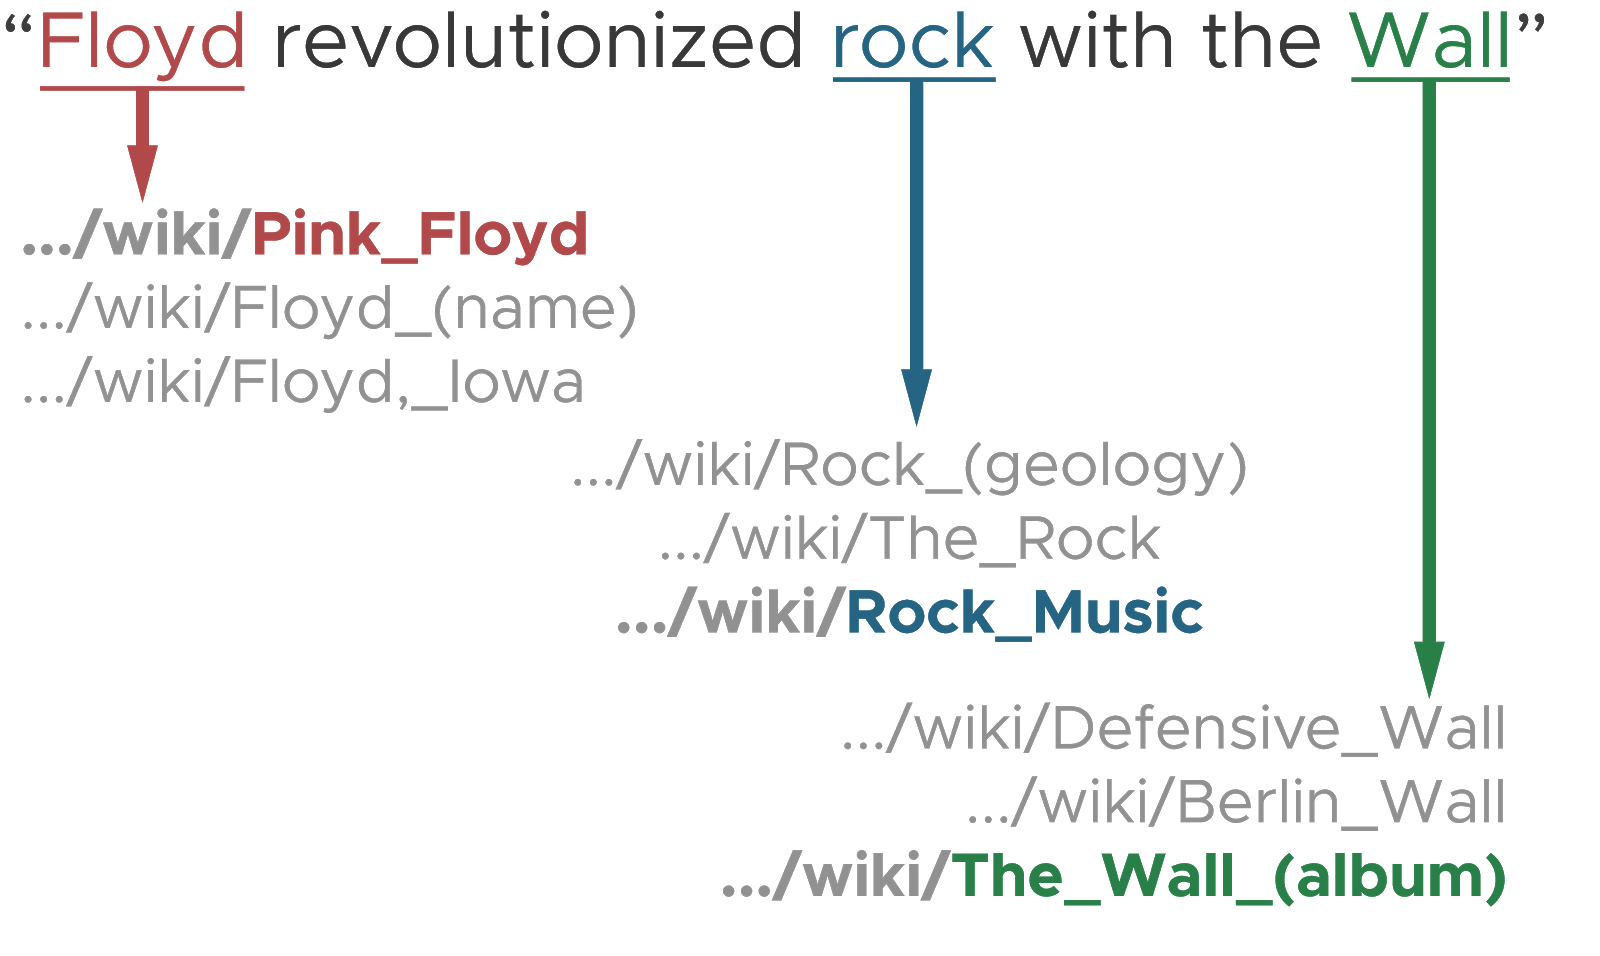

In [ ]:
import json

with open('workshop_license_keys_365.json') as f:
    license_keys = json.load(f)

license_keys.keys()


dict_keys(['PUBLIC_VERSION', 'JSL_VERSION', 'SECRET', 'SPARK_NLP_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET'])

In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

secret = license_keys['SECRET']

os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
version = license_keys['PUBLIC_VERSION']
jsl_version = license_keys['JSL_VERSION']

! pip install --ignore-installed -q pyspark==2.4.4

! python -m pip install --upgrade spark-nlp-jsl==$jsl_version  --extra-index-url https://pypi.johnsnowlabs.com/$secret

! pip install --ignore-installed -q spark-nlp==$version

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

In [ ]:
# Sample data
text = "The show also had a contestant named Donald Trump " \
               + "who later defeated Christina Aguilera on the way to become Female Vocalist Champion in the 1989 edition of Star Search in the United States. "
data = spark.createDataFrame([
            [text]]) \
            .toDF("text")


In [ ]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained()\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

sentence_embeddings = SentenceEmbeddings()\
  .setInputCols("sentence","embeddings")\
  .setOutputCol("sentence_embeddings")

ner_model = NerDLModel.pretrained() \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(["PER"])


glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


In [ ]:

disambiguator = NerDisambiguator() \
    .setS3KnowledgeBaseName("i-per") \
    .setInputCols("ner_chunk", "sentence_embeddings") \
    .setOutputCol("disambiguation") \
    .setNumFirstChars(5)


nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    sentence_embeddings,
    ner_model,
    ner_converter   ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [ ]:
result = model.transform(data)
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings| sentence_embeddings|                 ner|           ner_chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The show also had...|[[document, 0, 19...|[[document, 0, 18...|[[token, 0, 2, Th...|[[word_embeddings...|[[sentence_embedd...|[[named_entity, 0...|[[chunk, 37, 48, ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [ ]:
disambiguator.fit(result).transform(result).show()